In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import wlcave as wlcave #need to path correctly!

C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\getlimits.py:174: RuntimeWarning: divide by zero encountered in exp2
  eps=exp2(ld(-112)),
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\getlimits.py:53: RuntimeWarning: divide by zero encountered in log10
  self.precision = int(-log10(self.eps))
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\getlimits.py:54: RuntimeWarning: divide by zero encountered in power
  self.resolution = float_to_float(float_conv(10) ** (-self.precision))
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\getlimits.py:186: RuntimeWarning: divide by zero encountered in exp2
  epsneg_f80 = exp2(ld(-64))
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\getlimits.py:187: RuntimeWarning: divide by zero encountered in exp2
  tiny_f80 = exp2(ld(-16382))
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\getlimits.py:201: RuntimeWarning: divide by zero encountered in exp2
  eps=exp2(ld(-63)),
C:\Users\tmhab\anaconda3\lib\site-packages\nump

## Import Files From Simulation:

In [2]:
file = "C:\\users/tmhab/wlcsim_membrane/data/2.10.21_NoInteractions_2hrs_r11v0.txt"
data = np.loadtxt(file) #D:\\myfiles\welcome.txt


## Our Approach to Calculating Percolation Paths Through a Polymer Membrane:

### Defining The System:

In our system we have random copolymers with solvent molecules. Polymers are represented by beads of types 1 and 2 and solvent molecules are individual beads of type 0. No bead can overlap another. 

### Defining Percolation:

A percolation is a pathway through the polymer network that solvent molecules can move through. To form a percolation a solvent molecule will need to have at least one other solvent molecule adjacent to it within some path radius $r$

### What are we trying to learn from the system:

The goal in developing this code is to determine quantitatively the amount of percolation in a membrane. 

### Models for Percolation:
**1. Fire Spread Model:** In this model we measure the percolation paths by tracing the spots where the solvent molecules continue to be adjacent to the previous... It's easier to explain with a picture

## What we need to calculate:

Starting with the final equilibrium state we have x,y,z postion of a bead and it's identity (and also methylation state). We want to calculate percolation paths which will be represented by root mean square. 

#### What Percolation Model do we want to use:

1. Fire spead model:

Proceedure:
1. Pick a bead type
2. pick a random bead of that bead type
3. Check surround bead types to see if they are the same
    a. Pick a radius to search in


# Note: for some reason if you declare two different PolymerNetworks, they can interfere w/ each other (change values)

In [3]:
def generate_test_data(length=10,width=10,height=10,datapoints=500):
    X = np.random.random(datapoints)*length
    Y = np.random.random(datapoints)*width
    Z = np.random.random(datapoints)*height
    Beads = np.random.randint(3,size=(datapoints)).astype('uint8')
    Beads
    return X,Y,Z,Beads

#generate_test_data()

In [4]:
class Bead:
    '''
    '''
    def __init__(self, x, y, z, bead_type):
        self.x = x
        self.y = y
        self.z = z
        self.bead_type = bead_type
        


In [54]:
class Polymer:
    '''
    '''
    
    def __init__(self, bead_list):
        self.bead_list = bead_list
        bead_coor_array = np.zeros((len(bead_list), 3))
        bead_types = np.zeros(len(bead_list))
        for i, bead in enumerate(bead_list):
            bead_coor_array[i, 0] = bead.x
            bead_coor_array[i, 1] = bead.y
            bead_coor_array[i, 2] = bead.z
            bead_types[i] = bead.bead_type
        self.bead_coor_array = bead_coor_array
        self.bead_types = bead_types
    
    def print_bead_list(self):
        for i, bead in enumerate(self.bead_list):
            print("Bead " + str(i) + ": " + str(bead.x) + ", " + str(bead.y) + ", " + str(bead.z) + " Type: " + str(bead.bead_type))
   
    def find_center_of_mass(self,bead_num=0): 
        '''
        Find the center of mass for a given polymer chain wrt to a specific bead type
        '''
        X_bead = self.bead_coor_array[:,0][self.bead_types==bead_num] 
        Y_bead = self.bead_coor_array[:,1][self.bead_types==bead_num]
        Z_bead = self.bead_coor_array[:,2][self.bead_types==bead_num]
        
        x_center = np.mean(X_bead)
        y_center = np.mean(Y_bead)
        z_center = np.mean(Z_bead)
        
        return [x_center,y_center,z_center]
    
    def find_rg2(self): # INCORRECT- need to divid by total num of beads
        center_of_mass = self.find_center_of_mass()
        displacements = self.bead_coor_array - center_of_mass
        displacements_square = np.square(displacements)
        final_disp = np.sum(displacements_square, axis=1) #final disp square of sub polymer beads
        
        radius_g_2 = np.sum(final_disp)
        
        return radius_g_2
    
    def Radius_of_gyration_2(self,bead_num=0):
        center_of_mass_point = self.find_center_of_mass(bead_num)
        
        X_bead = self.bead_coor_array[:,0][self.bead_types==bead_num] 
        Y_bead = self.bead_coor_array[:,1][self.bead_types==bead_num]
        Z_bead = self.bead_coor_array[:,2][self.bead_types==bead_num]
        
        n = X_bead.shape[0]
        
        Rg2 = (np.sum((X_bead - center_of_mass_point[0])**2 + 
                    (Y_bead - center_of_mass_point[1])**2 + (Z_bead - center_of_mass_point[2])**2)/n)
        
        return Rg2

In [6]:
class PolymerNetwork:
    """
    This represents the postions of bead and their type (time invariant)
    
    Parameters
    ----------
    X : float [array] X 
    """
    
    def __init__(self,X,Y,Z, Beads, beads_per_polymer=40, persistence_length=2.03, bead_list=[], polymer_list=[]):
        self.X = X
        self.Y = Y
        self.Z = Z
        self.Beads = Beads
        self.beads_per_polymer = beads_per_polymer
        self.bead_list = bead_list
        self.polymer_list = polymer_list
        self.persistence_length = persistence_length
        self.create_beads()
        self.create_polymers()
        
        self.density = Beads.shape[0]/((max(X)-min(X)) * (max(Y)-min(Y)) * (max(Z)-min(Z)))
        
    def visualize(self):
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter3D(self.X[Beads==0], self.Y[Beads==0], self.Z[Beads==0],color='y')
        ax.scatter3D(self.X[Beads==1], self.Y[Beads==1], self.Z[Beads==1],color='r')
        ax.scatter3D(self.X[Beads==2], self.Y[Beads==2], self.Z[Beads==2],color='b')
        
    def nearest_neighbor(self,bead_num,radius):
        '''
        Find the average number of beads that surround a bead of the same type within the radius specified
        '''
        X_bead = self.X[Beads==bead_num]
        Y_bead = self.Y[Beads==bead_num]
        Z_bead = self.Z[Beads==bead_num]
        
        total_neighbors = 0
        for i in range(Beads[Beads==bead_num].shape[0]):
            point = np.array([X_bead[i],Y_bead[i],Z_bead[i]])
            displacement = np.sqrt((X_bead - point[0])**2 + (Y_bead - point[1])**2 + (Z_bead - point[2])**2)
            num_neighbor_points = displacement[displacement<=radius].shape[0] -1
            
            total_neighbors += num_neighbor_points

        return total_neighbors/(i+1)
    
    def create_beads(self):
        if len(self.bead_list) != 0:
            raise Exception("bead list already populated")
        for i in range(len(self.X)):
            bead = Bead(self.X[i], self.Y[i], self.Z[i], self.Beads[i])
            self.bead_list.append(bead)
    
    def print_bead_list(self):
        for i, bead in enumerate(self.bead_list):
            print("Bead " + str(i) + ": " + str(bead.x) + ", " + str(bead.y) + ", " + str(bead.z) + " Type: " + str(bead.bead_type))
    
    def create_polymers(self):
        if len(self.polymer_list) != 0:
            raise Exception("polymer list already populated")
        if len(self.bead_list) == 0:
            raise Exception("Need to run create_beads before create_polymers")
        for i in range(self.beads_per_polymer, len(self.bead_list) + 1, self.beads_per_polymer):
            polymer = Polymer(self.bead_list[i - self.beads_per_polymer : i])
            self.polymer_list.append(polymer)
        
    def print_polymer_list(self, verbose=False):
        for i, poly in enumerate(self.polymer_list):
            print("POLYMER " + str(i))
            if verbose:
                poly.print_bead_list()

In [7]:
'''
Determine the mean square interbead distance
Input: PolymerNetwork
       int skip_parameter: ratio of how many non-overlapping jumps of size d to skip when calculating the mean square 
       displacemnt between two beads distance d away. 1 means include all non-overlapping jumps,
       2 means every other, 3 means every third, etc.
Return: A DataFrame where the columns are a specific polymer in the network, rows are the number of "jumps" n,
        and the values are the average distance squared bewteen beads n jumps away (averaged over all different jumps 
        of size n possible in the polymer)
     <R^2> array of mean square end-to-end distances for all polymers with 0 to num_beads - 1 bonds
     non-dimensionalized by (2*l_p)^2
'''
def r2(polymer_network, skip_parameter=1):
    if len(polymer_network.bead_list) == 0:
        raise Exception("Need to run create_beads")
    if len(polymer_network.polymer_list) == 0:
        raise Exception("Need to run create_polymers")
    num_poly = len(polymer_network.polymer_list)
    avg_n_jumps = pd.DataFrame(index=range(polymer_network.beads_per_polymer), columns=range(num_poly))
    
    for i, poly in enumerate(polymer_network.polymer_list):
        # creating matrix of (inter-bead distances)^2 for a given polymer
        bead_dist = create_polymer_r2_table(poly)
        
        # get diagonals (non-overlapping jumps of size 0 - all beads), avg, store in the dataframe
        avg_n_jumps[i] = get_avg_jump_distances(poly, bead_dist, skip_parameter)
        
        if (i % 250 == 0):
            print("processed polymer " + str(i))
    
    #average the distance b/w chain ends, normailize (???)
    num_beads = polymer_network.beads_per_polymer
    r2_ave_vect = np.zeros(num_beads)
    for i in range(num_beads):
        row_avg = np.average(avg_n_jumps.iloc[i]) # average size i jump over all polymers
        r2_ave_vect[i] = row_avg
    
    #print("r2_ave before normalization = " + str(np.average(avg_n_jumps.iloc[num_beads-1])))
    #r2_ave = np.average(avg_n_jumps.iloc[num_beads-1])/(2 * polymer_network.persistence_length)**2
    
    return r2_ave_vect, avg_n_jumps

'''
Creates a 2D array with the square distance from each bead to each other bead in a polymer.
Inputs: Polymer class
Returns: 2D array of square distances
'''
def create_polymer_r2_table(polymer):
    num_beads = len(polymer.bead_list)
    bead_dist = np.zeros((num_beads, num_beads))
    for i, bead in enumerate(polymer.bead_coor_array):
        displacements = polymer.bead_coor_array - bead
        displacements_square = np.square(displacements)
        final_disp = np.sum(displacements_square, axis=1)
        bead_dist[i, :] = final_disp
        
    '''
    for j, bead1 in enumerate(polymer.bead_list):
        for k, bead2 in enumerate(polymer.bead_list):
            position1 = np.array([bead1.x, bead1.y, bead1.z])
            position2 = np.array([bead2.x, bead2.y, bead2.z])
            displacement_squared = np.sum((position2 - position1)**2)
            bead_dist[j][k] = displacement_squared
    '''
    return bead_dist

'''
Given a 2D array of square bead displacements, this function finds the average square distance of all 
non overlapping jumps, for all possible jump sizes. 
Inputs: Polymer
        polymer_bead_dist- 2D array of bead square displacements
        skip_parameter- ratio of how many non-overlapping jumps of size d to skip. 1 means include all non-overlapping
        jumps, 2 means every other, 3 means every third, etc.
Returns: n_jump_dist_avg- a 1D array where the index i corresponds to the average square displacement of a jump size i
'''
def get_avg_jump_distances(polymer, polymer_bead_dist, skip_parameter):
    num_beads = len(polymer.bead_list)
    n_jump_dist_avg = np.zeros(num_beads)
    for d in range(num_beads):   # for all jump sizes
            diag = np.diag(polymer_bead_dist, d) # get jumps of size d
            if d == 0:
                n_jump_dist_avg[d] = np.average(diag)
            else:
                n_jump_dist_avg[d] = np.average(diag[::skip_parameter*d])  # average all non-overlapping jumps
    return n_jump_dist_avg    

In [8]:
# TEST DATA:

# X,Y,Z,Beads = generate_test_data()
# PNet_Test = PolymerNetwork(X,Y,Z,np.zeros(len(X)), beads_per_polymer = 10)
# PNet_Test.density

In [9]:
# PNet_Test.visualize()

In [10]:
#PNet_Test.nearest_neighbor(bead_num=0,radius=0.4)
# polym = PNet_Test.polymer_list[0]
# polym.print_bead_list()
# print(polym.find_center_of_mass())
# print(polym.Radius_of_gyration())

In [11]:
#radii = np.linspace(0,15,100)
#for r in radii:
#    plt.plot(r,PNet_Test.nearest_neighbor(bead_num=0,radius=r),'y.')
#plt.xlabel('Radius')
#plt.ylabel('Average Number of Neighbor Points')

In [12]:
#x = r2(PNet_Test)
#x  # roughly random dist (no polymer chain)

In [13]:
#REAL DATA:

beads = np.zeros(len(data[:, 0]))   # no chemical identity data
no_interactions = PolymerNetwork(data[:, 0], data[:, 1], data[:, 2], beads, beads_per_polymer=40)

C:\Users\tmhab\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


In [14]:

print(len(no_interactions.bead_list)) # should be 80,000

80000


In [15]:

print(len(no_interactions.polymer_list)) #should be 2000

2000


In [16]:
r2_ave_vect, result = r2(no_interactions)

C:\Users\tmhab\anaconda3\lib\site-packages\pandas\core\dtypes\missing.py:262: RuntimeWarning: divide by zero encountered in isnan
  result = np.isnan(values)
C:\Users\tmhab\anaconda3\lib\site-packages\pandas\core\dtypes\missing.py:379: RuntimeWarning: divide by zero encountered in invert
  return ~res
C:\Users\tmhab\anaconda3\lib\site-packages\pandas\io\formats\format.py:1252: RuntimeWarning: divide by zero encountered in bitwise_and
  is_float_type = lib.map_infer(vals, is_float) & notna(vals)
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\_methods.py:45: RuntimeWarning: divide by zero encountered in reduce
  return umr_any(a, axis, dtype, out, keepdims)
C:\Users\tmhab\anaconda3\lib\site-packages\pandas\core\internals\managers.py:226: RuntimeWarning: divide by zero encountered in equal
  if (new_blknos == -1).any():
C:\Users\tmhab\anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in subtract
C:\Users\tmhab\anaconda3\lib\site-packag

processed polymer 0
processed polymer 250
processed polymer 500
processed polymer 750
processed polymer 1000
processed polymer 1250
processed polymer 1500
processed polymer 1750


C:\Users\tmhab\anaconda3\lib\site-packages\pandas\core\internals\managers.py:1110: RuntimeWarning: divide by zero encountered in invert
  new_blknos[~is_deleted] = np.arange(self.nblocks - len(removed_blknos))


In [17]:
print(r2_ave_vect)
result 

C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\arrayprint.py:885: RuntimeWarning: divide by zero encountered in isfinite
  finite_vals = data[isfinite(data)]
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\arrayprint.py:888: RuntimeWarning: divide by zero encountered in not_equal
  abs_non_zero = absolute(finite_vals[finite_vals != 0])
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\arrayprint.py:888: RuntimeWarning: divide by zero encountered in absolute
  abs_non_zero = absolute(finite_vals[finite_vals != 0])
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\arrayprint.py:894: RuntimeWarning: divide by zero encountered in double_scalars
  (min_val < 0.0001 or max_val/min_val > 1000.)):
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\arrayprint.py:968: RuntimeWarning: divide by zero encountered in isfinite
  if not np.isfinite(x):
C:\Users\tmhab\anaconda3\lib\site-packages\pandas\core\internals\managers.py:226: RuntimeWarning: divide by zero encountered in

[ 0.          0.16151278  0.59243728  1.24522628  2.07954993  3.06723617
  4.16569789  5.38538837  6.6487218   7.99208484  9.43793932 10.91659667
 12.37818563 13.89308667 15.4362178  17.04347128 18.64487326 20.22891804
 21.86025942 23.50434944 24.94745151 26.62523187 28.29599453 29.94128328
 31.55428672 33.20252514 34.84755739 36.54806549 38.21162255 39.91101385
 41.60153843 43.23246742 44.83438119 46.43516301 48.01264577 49.62889591
 51.19779563 52.80529516 54.39301144 56.05036629]


C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\_methods.py:30: RuntimeWarning: divide by zero encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
C:\Users\tmhab\anaconda3\lib\site-packages\pandas\io\formats\format.py:878: RuntimeWarning: divide by zero encountered in long_scalars
  lwidth -= np.array([self.adj.len(x) for x in idx]).max() + adjoin_width
C:\Users\tmhab\anaconda3\lib\site-packages\pandas\io\formats\format.py:1925: RuntimeWarning: divide by zero encountered in long_scalars
  w_adjoined = w + adjoin_width
C:\Users\tmhab\anaconda3\lib\site-packages\pandas\io\formats\format.py:1926: RuntimeWarning: divide by zero encountered in long_scalars
  curr_width += w_adjoined
C:\Users\tmhab\anaconda3\lib\site-packages\pandas\io\formats\format.py:1930: RuntimeWarning: divide by zero encountered in long_scalars
  wrap = curr_width + 2 > line_width and i > 0
C:\Users\tmhab\anaconda3\lib\site-packages\pandas\io\formats\format.py:1928: RuntimeWar

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.157959,0.147473,0.162123,0.171162,0.162561,0.162067,0.161183,0.154522,0.170941,0.160492,...,0.151643,0.160275,0.164059,0.162455,0.164502,0.158164,0.166980,0.166170,0.167712,0.165205
2,0.574533,0.549160,0.584291,0.626571,0.616642,0.601353,0.595330,0.565054,0.620521,0.593195,...,0.551825,0.585822,0.610149,0.601800,0.609381,0.566848,0.625966,0.593470,0.630145,0.595209
3,1.155976,1.179395,1.214368,1.318761,1.276532,1.260369,1.230608,1.188685,1.311302,1.233289,...,1.217028,1.286766,1.291160,1.268626,1.297717,1.218394,1.254425,1.288799,1.303457,1.255706
4,2.002388,1.891087,2.092197,2.065103,2.271605,2.145827,2.012835,1.760094,2.125436,2.012604,...,1.989987,2.051770,2.246046,2.029045,2.312009,2.095656,2.166242,2.149006,2.363098,1.950021
5,2.718192,2.596062,2.963646,3.143028,3.352720,3.179280,2.946224,2.635450,3.060645,2.772549,...,3.017031,3.008510,3.284773,3.197441,3.237589,2.838998,2.926162,3.253156,3.167626,2.635641
6,3.841749,3.502546,4.018099,4.069769,4.222490,4.509687,3.687525,3.610766,4.294624,3.938173,...,4.040649,3.386335,4.564999,4.418388,4.731706,3.881189,3.829188,3.867371,4.363755,3.849555
7,5.468836,3.956770,5.277126,4.600353,5.480911,5.530452,5.266811,4.162948,5.190584,4.970776,...,5.364221,5.052126,5.778548,5.732843,6.450962,5.051290,6.144148,5.324831,6.092218,4.531792
8,6.759105,5.748485,7.181959,5.340157,6.071908,6.127135,6.328008,5.391625,6.886879,6.510991,...,7.253022,5.963385,6.944149,7.423521,8.355813,6.506519,7.374955,7.837888,6.254794,4.540583
9,7.181217,6.738717,6.911374,8.573450,8.030048,8.277606,7.343234,7.277459,7.836084,7.823021,...,9.385375,6.737436,8.080345,7.645197,9.727783,8.614129,8.895220,7.710424,7.497201,5.639447


In [18]:
#wlc: kuhn length b ~= 2 * persistence length
kuhn_l = 2 * no_interactions.persistence_length
print(kuhn_l)
print(r2_ave_vect[1])

4.06
0.16151277946048911


Plotting Simulation mean R^2 values vs wlc_stat ideal

C:\Users\tmhab\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\tmhab\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\tmhab\wlcsim_membrane\wlcave.py:25: RuntimeWarning: divide by zero encountered in true_divide
  r2 = 2 * (length_kuhn / (dimensions - 1)
C:\Users\tmhab\wlcsim_membrane\wlcave.py:26: RuntimeWarning: divide by zero encountered in multiply
  - (1 - np.exp(-(dimensions - 1) * length_kuhn)) / (dimensions - 1) ** 2)
C:\Users\tmhab\wlcsim_membrane\wlcave.py:26: RuntimeWarning: divide by zero encountered in exp
  - (1 - np.exp(-(dimensions - 1) * length_kuhn)) / (dimensions - 1) ** 2)
C:\Users\tmhab\wlcsim_membrane\wlcave.py:26: RuntimeWarning: divide by zero encountered in subtract
  - (1 - np.exp(-(dimensions - 1) * length_kuhn)) / (dim

C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\legend.py:857: RuntimeWarning: divide by zero encountered in long_scalars
  for h, t in handles_and_labels[i0:i0 + di]]
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\transforms.py:417: RuntimeWarning: divide by zero encountered in double_scalars
  return (x0, y0, x1 - x0, y1 - y0)
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\axis.py:2182: RuntimeWarning: divide by zero encountered in double_scalars
  length = ((ends[1][0] - ends[0][0]) / self.axes.figure.dpi) * 72
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\axis.py:2188: RuntimeWarning: divide by zero encountered in double_scalars
  return int(np.floor(length / size))
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\axis.py:2188: RuntimeWarning: divide by zero encountered in floor
  return int(np.floor(length / size))
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\_methods.py:69: RuntimeWarning: divide by zero encountered in isnan
  return um.i

C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\axis.py:2029: RuntimeWarning: divide by zero encountered in double_scalars
  (x, bottom - self.labelpad * self.figure.dpi / 72)
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\transforms.py:1693: RuntimeWarning: divide by zero encountered in equal
  return np.all(self.get_matrix() == other.get_matrix())
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\axis.py:2059: RuntimeWarning: divide by zero encountered in double_scalars
  (x, bottom - self.OFFSETTEXTPAD * self.figure.dpi / 72)
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\text.py:388: RuntimeWarning: divide by zero encountered in double_scalars
  offsety = ymin + height - baseline / 2.0
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\axis.py:2323: RuntimeWarning: divide by zero encountered in double_scalars
  (left - self.labelpad * self.figure.dpi / 72, y)
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\mathtext.py:1766: RuntimeWarning: divide by

C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\transforms.py:714: RuntimeWarning: divide by zero encountered in maximum
  x0 = np.maximum(bbox1.xmin, bbox2.xmin)
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\transforms.py:715: RuntimeWarning: divide by zero encountered in minimum
  x1 = np.minimum(bbox1.xmax, bbox2.xmax)
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\transforms.py:716: RuntimeWarning: divide by zero encountered in maximum
  y0 = np.maximum(bbox1.ymin, bbox2.ymin)
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\transforms.py:717: RuntimeWarning: divide by zero encountered in minimum
  y1 = np.minimum(bbox1.ymax, bbox2.ymax)
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\axes\_base.py:4391: RuntimeWarning: divide by zero encountered in equal
  if np.all(clip_extent.extents == axbbox.extents):
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\spines.py:188: RuntimeWarning: divide by zero encountered in double_scalars
  bb0.x0 = bb0.x

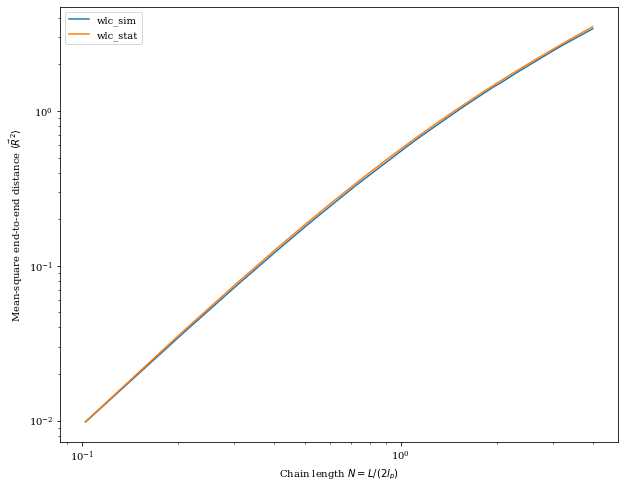

'\nISSUES:\n1 bead spacing squared = 0.174 simulation units\nmean square end-to-end distance of 2 bead polymer (1 jump) = 0.162 sim units\n\nHow much error is expected?\n'

In [19]:

#get wlc_sim r2 output normailized
nondimensionalization_constant = (2*no_interactions.persistence_length)**2
sim_r2_vals = r2_ave_vect[1:]/nondimensionalization_constant # nondimensionalized <r^2>

#get polymer lengths in terms of kuhn lengths (x-axis of plot)
bead_spacing = 16.26/39        # WLC_P__L / (WLC_P_NB - 1) == polymer length / num beads - 1. in simulation units 
bead_spacing_nm = bead_spacing * 28.7 # 1 simulation unit = 28.7 nm

sim_chain_lengths = np.zeros(39)
for i in range(1, 40):
    sim_chain_lengths[i-1] = bead_spacing_nm * i
    
length_kuhn = sim_chain_lengths / (2 * no_interactions.persistence_length * 28.7) #chain lengths from nm to Kuhn

#get wlc_stat r2 output
dimensions = 3
stat_r2_vals = wlcave.r2_ave(length_kuhn, dimensions)

#plot
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 10}
plt.rc('font', **font)
plt.loglog(length_kuhn, sim_r2_vals, label="wlc_sim") #WLC SIM
plt.loglog(length_kuhn, stat_r2_vals, label="wlc_stat")  #WLC STAT
#print("sim chain lenghts: ", sim_chain_lengths)
#print("sim r2 vals: ", sim_r2_vals)
plt.xlabel(r'Chain length $N = L/(2l_{p})$')# $N = L/(2l_{p})$')
plt.ylabel(r'Mean-square end-to-end distance $\langle \vec{R}^{2} \rangle$')
#plt.tight_layout()
plt.legend()
plt.show()

'''
ISSUES:
1 bead spacing squared = 0.174 simulation units
mean square end-to-end distance of 2 bead polymer (1 jump) = 0.162 sim units

How much error is expected?
'''

Radius of Gyration:

In [57]:
'''
Determine the mean square radius of gyration
Input: PolymerNetwork
       int skip_parameter: ratio of how many non-overlapping jumps of size d to skip when calculating the mean square 
       displacemnt between two beads distance d away. 1 means include all non-overlapping jumps,
       2 means every other, 3 means every third, etc.
Return: A DataFrame where the columns are a specific polymer in the network, rows are the size (number of bonds)
        of a given subpolymer,
        and the values are average radii of gyration of non-overlapping subpolymers of 
        a given size(averaged over all different jumps of that size possible in the polymer)

'''
def rg2(polymer_network, skip_parameter=1):
        
    num_poly = len(polymer_network.polymer_list)
    rg2_all_pos_polymers = pd.DataFrame(index=range(polymer_network.beads_per_polymer), columns=range(num_poly))
    
    for i, poly in enumerate(polymer_network.polymer_list):
        # creating array of square radii of gyrations for a given polymer (and all possible subpolymers)
        rg2_all_pos_polymers[i] = create_polymer_rg2_array(poly)
        
        if (i % 250 == 0):
            print("processed polymer " + str(i))
    
    #average the radii across all dif polymers in network
    num_beads = polymer_network.beads_per_polymer
    rg2_ave_vect = np.zeros(num_beads)
    for i in range(num_beads):
        row_avg = np.average(rg2_all_pos_polymers.iloc[i]) # average size i jump over all polymers
        rg2_ave_vect[i] = row_avg
    
    return rg2_ave_vect, rg2_all_pos_polymers


def create_polymer_rg2_array(polymer):
    '''
    Populates an array with the average radii of gyration squared of the polymer and every possible non-overlapping
    subpolymer

    The index of the array indicates the size of the subpolymer (# of bonds), so that
    the value at an index i is average radius of gyration of non-overlapping subpolymers of size i
    '''
    num_beads = len(polymer.bead_list)                         
    rg2_subpolymers = np.zeros(num_beads)     
    
    for d in range(1, num_beads+1):   # for all sub polymer sizes
        for i in range(0, num_beads, d): #for all non-overlapping subpolymers. d = num beads in subpolymer
            sub_bead_list = polymer.bead_list[i:i + d]
            if len(sub_bead_list) == d:
                sub_polymer = Polymer(sub_bead_list)
                radius_g_2 = sub_polymer.Radius_of_gyration_2()                 
                num_subpolymers = num_beads//d
                rg2_subpolymers[d-1] += radius_g_2/(num_subpolymers)
                
    return rg2_subpolymers


In [39]:
# #create_polymer_rg2_array logic
# polymer = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# num_beads = len(polymer)
# for d in range(1, num_beads+1):
#     print("d = ", d)
#     for i in range(0, num_beads, d):
#         sub_bead_list = polymer[i:i + d]
#         print("subpolymer: ", sub_bead_list)

d =  1
subpolymer:  [0]
subpolymer:  [1]
subpolymer:  [2]
subpolymer:  [3]
subpolymer:  [4]
subpolymer:  [5]
subpolymer:  [6]
subpolymer:  [7]
subpolymer:  [8]
subpolymer:  [9]
d =  2
subpolymer:  [0, 1]
subpolymer:  [2, 3]
subpolymer:  [4, 5]
subpolymer:  [6, 7]
subpolymer:  [8, 9]
d =  3
subpolymer:  [0, 1, 2]
subpolymer:  [3, 4, 5]
subpolymer:  [6, 7, 8]
subpolymer:  [9]
d =  4
subpolymer:  [0, 1, 2, 3]
subpolymer:  [4, 5, 6, 7]
subpolymer:  [8, 9]
d =  5
subpolymer:  [0, 1, 2, 3, 4]
subpolymer:  [5, 6, 7, 8, 9]
d =  6
subpolymer:  [0, 1, 2, 3, 4, 5]
subpolymer:  [6, 7, 8, 9]
d =  7
subpolymer:  [0, 1, 2, 3, 4, 5, 6]
subpolymer:  [7, 8, 9]
d =  8
subpolymer:  [0, 1, 2, 3, 4, 5, 6, 7]
subpolymer:  [8, 9]
d =  9
subpolymer:  [0, 1, 2, 3, 4, 5, 6, 7, 8]
subpolymer:  [9]
d =  10
subpolymer:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [58]:
rg2_ave_vect, result = rg2(no_interactions)

C:\Users\tmhab\anaconda3\lib\site-packages\pandas\core\dtypes\missing.py:262: RuntimeWarning: divide by zero encountered in isnan
  result = np.isnan(values)
C:\Users\tmhab\anaconda3\lib\site-packages\pandas\core\dtypes\missing.py:379: RuntimeWarning: divide by zero encountered in invert
  return ~res
C:\Users\tmhab\anaconda3\lib\site-packages\pandas\io\formats\format.py:1252: RuntimeWarning: divide by zero encountered in bitwise_and
  is_float_type = lib.map_infer(vals, is_float) & notna(vals)
C:\Users\tmhab\anaconda3\lib\site-packages\pandas\core\internals\managers.py:226: RuntimeWarning: divide by zero encountered in equal
  if (new_blknos == -1).any():
C:\Users\tmhab\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in equal
C:\Users\tmhab\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in equal
C:\Users\tmhab\anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide b

processed polymer 0
processed polymer 250
processed polymer 500
processed polymer 750
processed polymer 1000
processed polymer 1250
processed polymer 1500
processed polymer 1750


C:\Users\tmhab\anaconda3\lib\site-packages\pandas\core\internals\managers.py:1110: RuntimeWarning: divide by zero encountered in invert
  new_blknos[~is_deleted] = np.arange(self.nblocks - len(removed_blknos))


In [59]:
result


C:\Users\tmhab\anaconda3\lib\site-packages\pandas\core\internals\managers.py:226: RuntimeWarning: divide by zero encountered in equal
  if (new_blknos == -1).any():
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\_methods.py:45: RuntimeWarning: divide by zero encountered in reduce
  return umr_any(a, axis, dtype, out, keepdims)
C:\Users\tmhab\anaconda3\lib\site-packages\pandas\core\dtypes\missing.py:262: RuntimeWarning: divide by zero encountered in isnan
  result = np.isnan(values)
C:\Users\tmhab\anaconda3\lib\site-packages\pandas\io\formats\format.py:1375: RuntimeWarning: divide by zero encountered in invert
  imask = (~mask).ravel()
C:\Users\tmhab\anaconda3\lib\site-packages\pandas\io\formats\format.py:1418: RuntimeWarning: divide by zero encountered in absolute
  abs_vals = np.abs(self.values)
C:\Users\tmhab\anaconda3\lib\site-packages\pandas\io\formats\format.py:1422: RuntimeWarning: divide by zero encountered in greater
  has_large_values = (abs_vals > 1e6).any()
C:\Users\t

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.041412,0.036620,0.041449,0.042382,0.040465,0.039344,0.040801,0.037810,0.042891,0.040639,...,0.038705,0.039252,0.042224,0.041275,0.042304,0.042607,0.042140,0.041594,0.040682,0.042920
2,0.094731,0.092401,0.101459,0.105937,0.101563,0.100917,0.098338,0.097702,0.104776,0.102127,...,0.090467,0.107590,0.104220,0.102335,0.099744,0.097585,0.108670,0.107856,0.109915,0.106987
3,0.180465,0.167416,0.181453,0.176562,0.192914,0.170524,0.183697,0.171097,0.190140,0.184094,...,0.166607,0.189848,0.185881,0.185686,0.190267,0.180303,0.186162,0.186688,0.204668,0.192674
4,0.278935,0.256651,0.262125,0.302886,0.283864,0.289613,0.282209,0.264236,0.292641,0.269456,...,0.280439,0.282624,0.265663,0.284374,0.279585,0.275653,0.282678,0.288557,0.303628,0.292783
5,0.367081,0.340213,0.395052,0.406057,0.412499,0.419704,0.369957,0.367465,0.374851,0.356883,...,0.375078,0.363284,0.390321,0.393603,0.412751,0.353686,0.389529,0.376297,0.419065,0.389275
6,0.529340,0.423712,0.529613,0.468248,0.534672,0.527843,0.522835,0.437695,0.524387,0.495741,...,0.489555,0.494773,0.542256,0.533545,0.599996,0.512002,0.581632,0.537261,0.538067,0.498173
7,0.640500,0.578313,0.690067,0.668281,0.643203,0.607892,0.651070,0.588086,0.732999,0.625794,...,0.634934,0.625010,0.651388,0.730114,0.705800,0.630391,0.682514,0.699127,0.685181,0.579425
8,0.812796,0.662582,0.767828,0.867041,0.827075,0.783673,0.767422,0.767979,0.781306,0.783361,...,0.852192,0.756681,0.788423,0.829898,0.873619,0.795429,0.938954,0.829134,0.788575,0.650042
9,0.886138,0.841877,0.918959,1.021824,0.967735,0.954957,0.928229,0.894274,0.951104,0.977118,...,1.034019,0.936591,0.907072,0.992576,1.042576,1.054628,0.984993,0.894993,1.071750,0.927744


In [60]:
print(rg2_ave_vect)

[0.         0.04040731 0.10179213 0.18226466 0.27989841 0.39231403
 0.51982947 0.65851077 0.80669431 0.9676535  1.13861614 1.31606095
 1.4998934  1.69045634 1.88960244 2.09485439 2.30403144 2.51682794
 2.7332337  2.95241728 3.16008644 3.38818565 3.61965442 3.85359044
 4.08894499 4.32646416 4.56609123 4.80893791 5.05380477 5.30120003
 5.55073075 5.80136448 6.05295435 6.30543541 6.55846534 6.81282365
 7.06752698 7.32329969 7.57951183 7.83693596]


C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\arrayprint.py:885: RuntimeWarning: divide by zero encountered in isfinite
  finite_vals = data[isfinite(data)]
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\arrayprint.py:888: RuntimeWarning: divide by zero encountered in not_equal
  abs_non_zero = absolute(finite_vals[finite_vals != 0])
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\arrayprint.py:888: RuntimeWarning: divide by zero encountered in absolute
  abs_non_zero = absolute(finite_vals[finite_vals != 0])
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: divide by zero encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\arrayprint.py:894: RuntimeWarning: divide by zero encountered in double_scalars
  (min_val < 0.0001 or max_val/min_val > 1000.)):
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\arrayprint.py:968: RuntimeWarning: divide

Plotting Simulation mean Rg^2 values vs wlc_stat ideal

C:\Users\tmhab\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\tmhab\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\tmhab\wlcsim_membrane\wlcave.py:54: RuntimeWarning: divide by zero encountered in true_divide
  - length_kuhn ** -2 * (1 - np.exp(-(dimensions - 1) * length_kuhn)) / (dimensions - 1) ** 4)
C:\Users\tmhab\wlcsim_membrane\wlcave.py:54: RuntimeWarning: divide by zero encountered in subtract
  - length_kuhn ** -2 * (1 - np.exp(-(dimensions - 1) * length_kuhn)) / (dimensions - 1) ** 4)
C:\Users\tmhab\wlcsim_membrane\wlcave.py:54: RuntimeWarning: divide by zero encountered in reciprocal
  - length_kuhn ** -2 * (1 - np.exp(-(dimensions - 1) * length_kuhn)) / (dimensions - 1) ** 4)
C:\Users\tmhab\wlcsim_membrane\wlcave.py:54: RuntimeWarni

C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\axis.py:2188: RuntimeWarning: divide by zero encountered in double_scalars
  return int(np.floor(length / size))
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\axis.py:2188: RuntimeWarning: divide by zero encountered in floor
  return int(np.floor(length / size))
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\_methods.py:69: RuntimeWarning: divide by zero encountered in isnan
  return um.isnan(a)
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: divide by zero encountered in clip
  return ufunc(*args, out=out, **kwargs)
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\ticker.py:2327: RuntimeWarning: divide by zero encountered in long_scalars
  (numdec + 1) // numticks + 1)
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\ticker.py:2333: RuntimeWarning: divide by zero encountered in long_scalars
  decades = np.arange(math.floor(log_vmin) - stride,
C:\Users\tmhab\anaconda3\li

C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\text.py:678: RuntimeWarning: divide by zero encountered in isfinite
  if not np.isfinite(posx) or not np.isfinite(posy):
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\text.py:698: RuntimeWarning: divide by zero encountered in double_scalars
  x = x + posx
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\text.py:699: RuntimeWarning: divide by zero encountered in double_scalars
  y = y + posy
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\text.py:701: RuntimeWarning: divide by zero encountered in double_scalars
  y = canvash - y
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.round(x + ox + xd)
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:161: RuntimeWarning: divide by zero encountered in double_scalars
  y = np.round(y - oy + yd)
C:\Users\tmhab\anaconda3\lib\site-packages\matplo

C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\transforms.py:714: RuntimeWarning: divide by zero encountered in maximum
  x0 = np.maximum(bbox1.xmin, bbox2.xmin)
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\transforms.py:715: RuntimeWarning: divide by zero encountered in minimum
  x1 = np.minimum(bbox1.xmax, bbox2.xmax)
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\transforms.py:716: RuntimeWarning: divide by zero encountered in maximum
  y0 = np.maximum(bbox1.ymin, bbox2.ymin)
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\transforms.py:717: RuntimeWarning: divide by zero encountered in minimum
  y1 = np.minimum(bbox1.ymax, bbox2.ymax)
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\axes\_base.py:4391: RuntimeWarning: divide by zero encountered in equal
  if np.all(clip_extent.extents == axbbox.extents):
C:\Users\tmhab\anaconda3\lib\site-packages\matplotlib\spines.py:188: RuntimeWarning: divide by zero encountered in double_scalars
  bb0.x0 = bb0.x

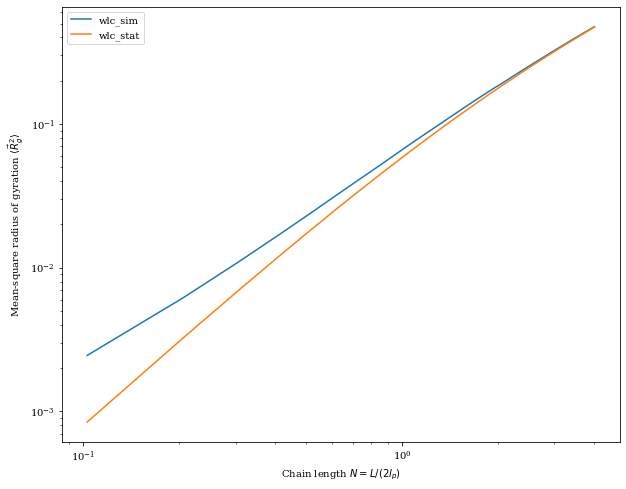

In [61]:

#get wlc_sim rg2 output normailized
nondimensionalization_constant = (2*no_interactions.persistence_length)**2
sim_rg2_vals = rg2_ave_vect[1:]/nondimensionalization_constant # nondimensionalized <r^2>

#get polymer lengths in terms of kuhn lengths (x-axis of plot)
bead_spacing = 16.26/39        # WLC_P__L / (WLC_P_NB - 1) == polymer length / num beads - 1. in simulation units 
bead_spacing_nm = bead_spacing * 28.7 # 1 simulation unit = 28.7 nm

sim_chain_lengths = np.zeros(39)
for i in range(1, 40):
    sim_chain_lengths[i-1] = bead_spacing_nm * i
    
length_kuhn = sim_chain_lengths / (2 * no_interactions.persistence_length * 28.7) #chain lengths from nm to Kuhn

#get wlc_stat rg2 output
dimensions = 3
stat_rg2_vals = wlcave.rg2_ave(length_kuhn, dimensions)

#plot
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 10}
plt.rc('font', **font)
plt.loglog(length_kuhn, sim_rg2_vals, label="wlc_sim") #WLC SIM
plt.loglog(length_kuhn, stat_rg2_vals, label="wlc_stat")  #WLC STAT
#print("sim chain lenghts: ", sim_chain_lengths)
#print("sim r2 vals: ", sim_r2_vals)
plt.xlabel(r'Chain length $N = L/(2l_{p})$')# $N = L/(2l_{p})$')
plt.ylabel(r'Mean-square radius of gyration $\langle \vec{R}_g^{2} \rangle$')
#plt.tight_layout()
plt.legend()
plt.show()
'''
ISSUES:
at low chain length, high error
How much error is expected?
'''